# Anàlisi i exploració dels espectres atmosfèrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.ticker as mticker

## Càrrega de dades

In [2]:
# Noms de les variables espectrals (longituds d'ona)
wl_names = np.load('/kaggle/input/tfm2a-preparar-dades/X_names.npy')
wl_grid = np.asarray([str(i).replace( 'wl_', '') for i in wl_names]).astype(float)
wl_grid.shape

(52,)

In [3]:
# Espectres atmosfèrics (variables predictores)
X_data = np.load('/kaggle/input/tfm2a-preparar-dades/X_minMaxScaled_opt.npy')
X_data.shape

(91392, 52)

In [4]:
# Paràmetres atmosfèrics (variables resposta)
Y_FM = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM.npy')
Y_FM_names = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM_names.npy')
FM_df = pd.DataFrame(Y_FM, columns=Y_FM_names)
FM_df.head(3)

,planet_temp,log_H2O,log_CO2,log_CH4,log_CO,log_NH3
0,1108.725067,-6.484809,-7.016512,-3.294729,-3.351913,-6.955828
1,636.858130,-8.829193,-8.603965,-5.501124,-4.799371,-6.020019
2,420.527609,-6.626830,-6.420932,-6.755727,-5.318471,-4.695118


# Gràfic amb les dades reescalades

Espectre mitjà de TOTS els espectres de la base de dades.

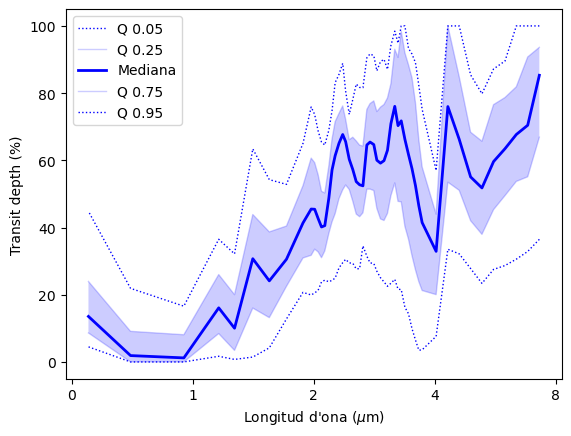

In [5]:
# AMB LES DADES REESCALADES
fig, ax = plt.subplots(1)
ax.plot(wl_grid, np.quantile(X_data, 0.05, axis=0), lw=1, label='Q 0.05', color='blue', linestyle='dotted')
ax.plot(wl_grid, np.quantile(X_data, 0.25, axis=0), lw=1, label='Q 0.25', color='blue', linestyle='solid', alpha=0.2)
ax.plot(wl_grid, np.quantile(X_data, 0.5, axis=0), lw=2, label='Mediana', color='blue', linestyle='solid')
ax.plot(wl_grid, np.quantile(X_data, 0.75, axis=0), lw=1, label='Q 0.75', color='blue', linestyle='solid', alpha=0.2)
ax.plot(wl_grid, np.quantile(X_data, 0.95, axis=0), lw=1, label='Q 0.95', color='blue', linestyle='dotted')
ax.fill_between(wl_grid, np.quantile(X_data, 0.25, axis=0), np.quantile(X_data, 0.75, axis=0), facecolor='blue', alpha=0.2)
ax.legend(loc='upper left')
ax.set_xlabel("Longitud d'ona ($\mu$m)")
ax.set_ylabel('Transit depth (%)')
ax.set_xscale('log', base=2)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))


# Agrupacions d'espectres amb característiques homogènies

### Reducció de la dimensionalitat amb Anàlisi de Components Principals (PCA)

In [6]:
from sklearn.decomposition import PCA

# Creem una instància del model PCA
pca = PCA(n_components=2)
# Ajustem el model amb les dades i guardem els valors transformats:
pca_results = pca.fit_transform(X_data)

# Variància explicada per cada component
components_var = pca.explained_variance_ratio_ * 100
print("Variància explicada per cada component: ", components_var)

# Variancia explicada acumulada 
total_var = np.sum(pca.explained_variance_ratio_ * 100)
print("Variància total explicada: ", round(total_var,1), "%")

Variància explicada per cada component:  [46.14083587 28.98737801]
Variància total explicada:  75.1 %


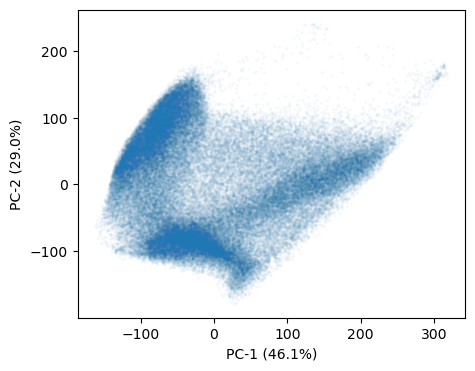

In [7]:
# Visualització de les dades projectades en les dues primeres dimensions de la PCA:
 
fig, ax = plt.subplots(figsize = (5, 4))
plt.scatter(pca_results[:,0], pca_results[:,1], s=2, alpha=0.025)
plt.xlabel("PC-1 (" + str(round(components_var[0],1)) + "%)")
plt.ylabel("PC-2 (" + str(round(components_var[1],1)) + "%)")
plt.show()


### Separació dels agregats amb DBSCAN

2023-06-18 11:32:29.617051
2023-06-18 11:32:31.469983


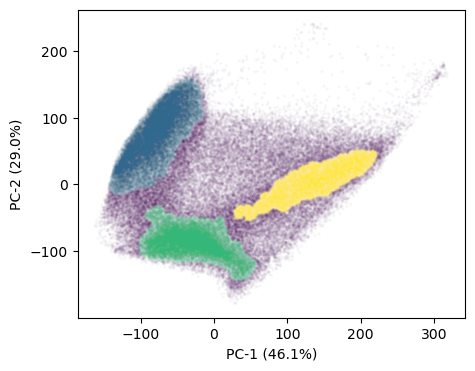

2023-06-18 11:32:32.901430


In [8]:
from sklearn.cluster import DBSCAN

print(datetime.datetime.now())
db = DBSCAN(eps=6, min_samples=167).fit(pca_results)
labels = db.labels_
print(datetime.datetime.now())


fig, ax = plt.subplots(figsize = (5, 4))
plt.scatter(pca_results[:,0], pca_results[:,1], c = labels, s=2, alpha=0.025)
plt.xlabel("PC-1 (" + str(round(components_var[0],1)) + "%)")
plt.ylabel("PC-2 (" + str(round(components_var[1],1)) + "%)")
#ax.set(xscale="log", yscale="log")
plt.show()
print(datetime.datetime.now())

In [9]:
# Guardem les etiquetes dels grups de la PCA per futures anàlisis
np.save('/kaggle/working/PCA_labels', labels)
#np.load('/kaggle/working/PCA_labels.npy')

In [10]:
# Labels dels grups
print(np.unique(labels))

[-1  0  1  2]


In [11]:
# Quantes mostres tenim a cada grup:
print(X_data[labels == 0,:].shape)
print(X_data[labels == 1,:].shape)
print(X_data[labels == 2,:].shape)

(26004, 52)
(21760, 52)
(12555, 52)


## Espectre mitjà de cada grup

In [12]:
def espectre_tipus(dades, i):
    #fig, ax = plt.subplots(1)
    ax[i].plot(wl_grid, np.quantile(dades, 0.05, axis=0), lw=1, label='Q 0.05', color='blue', linestyle='dotted')
    ax[i].plot(wl_grid, np.quantile(dades, 0.25, axis=0), lw=1, label='Q 0.25', color='blue', linestyle='solid', alpha=0.2)
    ax[i].plot(wl_grid, np.quantile(dades, 0.5, axis=0), lw=2, label='Mediana', color='blue', linestyle='solid')
    ax[i].plot(wl_grid, np.quantile(dades, 0.75, axis=0), lw=1, label='Q 0.75', color='blue', linestyle='solid', alpha=0.2)
    ax[i].plot(wl_grid, np.quantile(dades, 0.95, axis=0), lw=1, label='Q 0.95', color='blue', linestyle='dotted')
    ax[i].fill_between(wl_grid, np.quantile(dades, 0.25, axis=0), np.quantile(dades, 0.75, axis=0), facecolor='blue', alpha=0.2)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel("Longitud d'ona ($\mu$m)")
    ax[i].set_ylabel('Transit depth (%)')
    ax[i].set_xscale('log', base=2)
    ax[i].xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

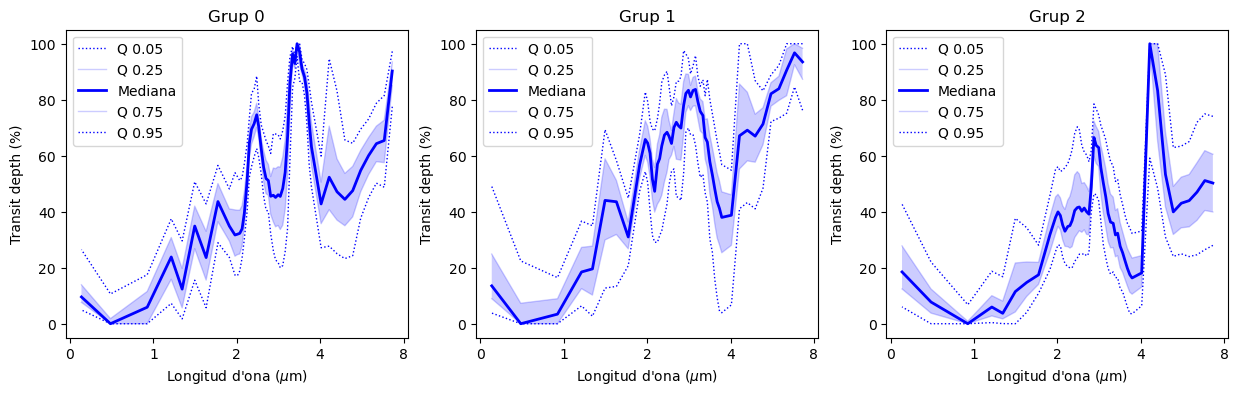

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

espectre_tipus(X_data[labels == 0,:], 0)
ax[0].set_title("Grup 0")
espectre_tipus(X_data[labels == 1,:], 1)
ax[1].set_title("Grup 1")
espectre_tipus(X_data[labels == 2,:], 2)
ax[2].set_title("Grup 2")

plt.show()

### Propietats atmosfèriques de cada grup d'espectres

In [14]:
df = pd.DataFrame()
df['wl'] = wl_grid
df['mediana'] = np.quantile(X_data[labels == 2,:], 0.5, axis=0)

df = df[df.wl > 2 ]
df.loc[df['mediana'].idxmax()]

wl           4.31
mediana    100.00
Name: 8, dtype: float64

In [15]:
FM_df['grup'] = labels
FM_df.head(5)

,planet_temp,log_H2O,log_CO2,log_CH4,log_CO,log_NH3,grup
0,1108.725067,-6.484809,-7.016512,-3.294729,-3.351913,-6.955828,0
1,636.858130,-8.829193,-8.603965,-5.501124,-4.799371,-6.020019,-1
2,420.527609,-6.626830,-6.420932,-6.755727,-5.318471,-4.695118,1
3,1370.906116,-7.639372,-5.877303,-4.476840,-5.200010,-6.240726,0
4,746.170076,-4.172605,-6.899335,-6.360434,-4.140252,-8.896858,1


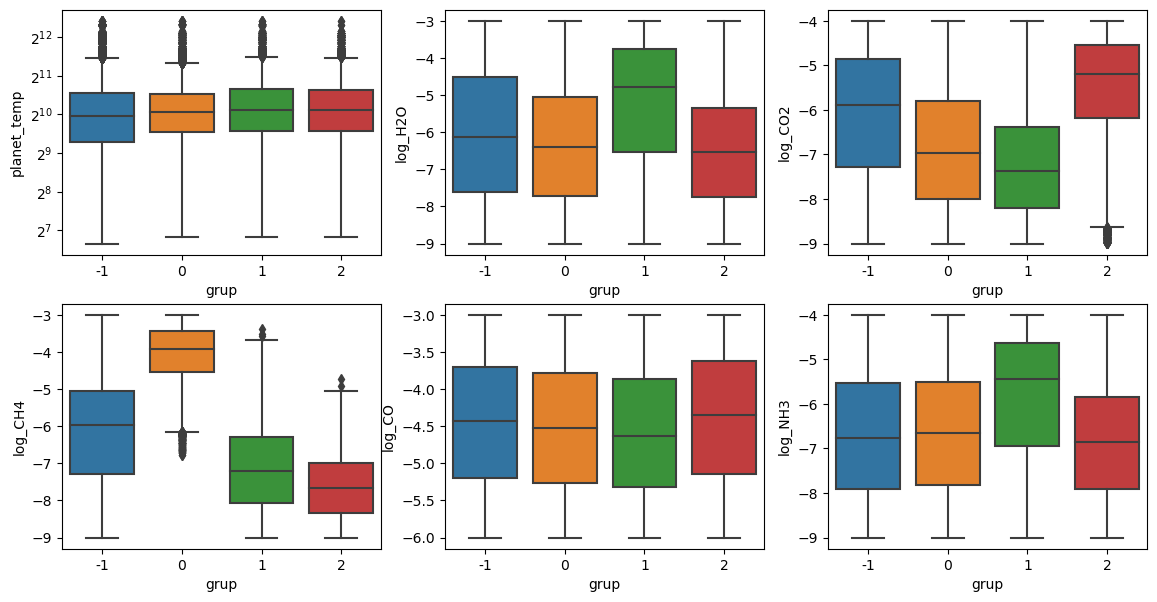

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(14, 7))

sns.boxplot(x='grup', y='planet_temp', data = FM_df, ax=axs[0, 0])
axs[0,0].set_yscale('log', base=2)
sns.boxplot(x='grup', y='log_H2O', data = FM_df, ax=axs[0, 1])
sns.boxplot(x='grup', y='log_CO2', data = FM_df, ax=axs[0, 2])
sns.boxplot(x='grup', y='log_CH4', data = FM_df, ax=axs[1, 0])
sns.boxplot(x='grup', y='log_CO', data = FM_df, ax=axs[1, 1])
sns.boxplot(x='grup', y='log_NH3', data = FM_df, ax=axs[1, 2])
plt.show()